In [2]:
import numpy as np 
import pandas as pd 
import numpy as np 
import pandas as pd
import xarray as xr
import openpyxl
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import *
import matplotlib.colors as colors
from scipy import stats 
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.mpl.ticker as cticker
from cartopy.util import add_cyclic_point


In [3]:
iyr=2000
fyr=2023
domain='GRa'
domainO='MARMer'
variable='pr'
var='pr'
units='mm/month'
exp='obs'

model1='MAR'
res1='5x5km'

model2='chirps'
res2='0.05°x0.05°'

model3='cru'

model4='aphro'
res4=str('0.25°x0.25°')

model5='gpcp'
res5=str('1.0°x1.0°')



titles = {
    'MAM': 'MAM',
    'JJAS': 'JJAS',
    'ON': 'ON',
    'DJF': 'DJF',
}

station='Naulek'


In [4]:
## GRID Model MAR
sourceDataGrid='/home/amoryc/'
#fileName_grF='NST.2000.01.01.00.GRa_Fedchenko.nc'
fileName_grM='NST.2000.01.01.00.GRa_Mera.nc_ICEmask'
ds_grM= xr.open_dataset(sourceDataGrid+fileName_grM)

In [5]:
sourceData='/bettik/PROJECTS/pr-regional-climate/santolam/'

In [6]:
####
## MAR
####
sourceData1='/bettik/PROJECTS/pr-regional-climate/santolam/MARout/GRa/spin2/work/monthly/'
variable='TTZ' ##RF;SF;SHSN3;TT
fileName1='TTZ_mon_MARv3.14_ER5_spin2_GRa_2000-2023.nc' ##change to monthly
dsM= xr.open_dataset(sourceData1+fileName1)['TTZ'][:,1,:,:] ## montlhy mean
FieldMAR = dsM.rename({'TIME': 'time'})

In [7]:
####
## CRU
####

res3=str('0.5°x0.5°')

fileName3='cru_ts4.05.1901.2020.tmp.dat_remapMARMer.nc'
ds3 = xr.open_dataset(sourceData+model3+'/'+fileName3)['tmp']
print(ds3.attrs)
FieldCRU=ds3.sel(time=slice(str(iyr)+'-01',str(fyr)+'-12'))
#units in mm/month -> mm/day
#field50=dom.field_dom(ds5,domain)
#month_length5 = field50.time.dt.days_in_month
#
#field5=field50/month_length5

FieldCRU=FieldCRU.rename({'lat': 'lat3'})
FieldCRU=FieldCRU.rename({'lon': 'lon3'})

{'long_name': 'near-surface temperature', 'units': 'degrees Celsius', 'correlation_decay_distance': np.float32(1200.0)}


In [41]:
#####
## Opening station data + Deff Var 
#####
path="/bettik/PROJECTS/pr-regional-climate/santolam/glacioclim/donnees_meteo/Naulekfinal2012_24.xlsx"
xl_data=pd.ExcelFile(path)                           
df= {sheet_name: xl_data.parse(sheet_name)     
       for sheet_name in xl_data.sheet_names}
Data=df['Naulekfinal2012_24']                  
NameVars=['Time','Tairlow','RHlow','Tairhight','RHhight','u','Direction','SWin','SWout','LWincor','LWoutcor','Abl/acc dist sensor surf','tilt metter XAXIS','tilt meter YAXIX']
UnitVars=['data/hour','C','%','C','%','m/s','degrees','W/m2','W/m2','W/m2','W/m2','m','degrees','degrees']

##Define new DataFrame and changing name of columns
dfile= pd.DataFrame(data=Data.loc[4:]) 
df=pd.DataFrame(dfile.values, columns=NameVars) 
### Opening one column + converting into an array
Tairlow_ar=[float(i) for i in df.Tairlow.values]   #Convertit les données en float utilisables 
Tairhight_ar=[float(i) for i in df.Tairhight.values] 
#Pour l'utilisation des données avec xarray, redéfinitions des variables en prenant en compte la fréquence à laquelle les données sont prises ( ici 30 min ) 
def NewTime(
        NameVar,
        Var_ar,
        freq):
    start, end = df.Time.values[0], df.Time.values[-1]
    time = pd.date_range(start, end, freq=freq)
    ds = xr.Dataset({NameVar: ("time",np.asarray(Var_ar)), "time": time})
    return ds 
    
Tlow=NewTime('Tairlow',Tairlow_ar,'30min')
Thight=NewTime('Tairhight',Tairhight_ar,'30min')
T=xr.Dataset()
T['Tair']=Tlow.Tairlow
#T['Tair']=Thight.Tairhight#faire égal à ça si différent de Nan et égal à Tlow sinon.
#T['Tair']= ((Tlow.Tairlow+Thight.Tairhight)/2) #faire égal à ça si différent de Nan et égal à Tlow sinon.

In [42]:
######
## Finding Pixel MAR (i,j)
######

#Glacioclim station location

lon_Station_Glacioclim=86.89739046
lat_Station_Glacioclim=27.71772341
elev_Station_Glacioclim=5350.000

##Find the pixel of MAR corresponding to station
target_lon = lon_Station_Glacioclim
target_lat = lat_Station_Glacioclim
lon=ds_grM.LON
lat=ds_grM.LAT


#Step 2: Find the nearest grid point to target_lon,target_lat
# Compute distance to each grid point
dist = np.sqrt((lon - target_lon)**2 + (lat - target_lat)**2)
#print(dist)
j, i = np.unravel_index(dist.argmin(), dist.shape)

#Step 3: Extract data at that location
# For a single time step
#value = dsM['SH'].isel(y=j, x=i)
## If there's a time dimension
dsM_MAR=FieldMAR[0:, i, j]

#units=dsM.units

#BONUS FOR MAR
SH_sta=elev_Station_Glacioclim
value = ds_grM['SH'].isel(y=j, x=i)
diff=SH_sta-value.values
value.values,SH_sta, diff
print(i,j)

99 39


In [43]:
######
## Finding Pixel CRU (m,n)
######
##Find the pixel of Chirps corresponding to station
target_lon = lon_Station_Glacioclim
target_lat = lat_Station_Glacioclim
lon3=FieldCRU.lon3
lat3=FieldCRU.lat3
#Step 2: Find the nearest grid point to target_lon,target_lat
# Compute distance to each grid point
dist = np.sqrt((lon3 - target_lon)**2 + (lat3 - target_lat)**2)
n, m = np.unravel_index(dist.argmin(), dist.shape)
print(m,n)
#Step 3: Extract data at that location
# For a single time step
#value = dsM['SH'].isel(y=j, x=i)
## If there's a time dimension

dsM_CRU=FieldCRU[0:, m, n]

99 39


In [44]:
######
## Definition fonctions
######


#Définition des Saisons, et création d'une fonction qui définit les saisons en fonction des périodes des moussons:
seasons = {
	'MAM': [3, 4, 5],  	
	'JJAS': [6, 7, 8, 9],  
	'ON': [10, 11],    	
	'DJF': [12, 1, 2]  	
}
def seasonsdata(ds, season_name): 
	x = seasons[season_name]
	return ds.sel(time=ds['time'].dt.month.isin(x))

#Fonction Clim de base 

#Util pour les Températures exprimées dans les fichiers glacioclim
def Clim_mean(ds, variable):
    daily = ds[variable].resample(time='D').mean()
    monthly = daily.resample(time='ME').mean()
    yearly = monthly.resample(time='YE').mean()

    return {
        'daily': daily.to_dataset(name=variable),
        'monthly': monthly.to_dataset(name=variable),
        'yearly': yearly.to_dataset(name=variable)
    }

#Util pour les Précips exprimées dans les fichiers glacioclim
def Clim_sum(ds, variable):
    daily = ds[variable].resample(time='D').sum()
    monthly = daily.resample(time='ME').sum()
    yearly = monthly.resample(time='YE').sum()

    return {
        'daily': daily.to_dataset(name=variable),
        'monthly': monthly.to_dataset(name=variable),
        'yearly': yearly.to_dataset(name=variable)
    }


# Precip sta classic climatic variables. Donne un DataArray, Timeseries des moyennes de précip saisonnières sur la période considérée

def seasonal_annual_clim(datasets, seasons):

    return {
        name: {
            season: seasonsdata(ds, season).resample(time='YE').mean()
            for season in seasons
        }
        for name, ds in datasets.items()
    }

#Même fonction mais pour les données des Models considérés.
def Model_seasonal_timeseries(ds, model_name='Chirps'):
    # Suffixes pour noms de variable
    suffix_map = {
        'MAM': 'premon',
        'JJAS': 'mon',
        'ON': 'postmon',
        'DJF': 'hiver'
    }

    seasonal_dict = {}

    for season, suffix in suffix_map.items():
        ts = seasonsdata(ds, season).resample(time='YE').mean()
        var_name = f'Timeseries_{model_name}_{suffix}'
        globals()[var_name] = ts  # Création de la variable globale
        seasonal_dict[season] = ts

    return seasonal_dict

In [45]:
######
## Premier Traitement climato
######

In [46]:
#Précip station
Clim_Temp_station=Clim_mean(T,'Tair')
#définition temps commun pour toutes les données ( bordés sur celle de station en entrée, et la première donnée à manquer en sortie[aussi station])

time1 = Clim_Temp_station['monthly']['time']# début 
start=time1[0] 
end=time1[-1]




T_sta=Clim_Temp_station['monthly'].sel(time=slice(start,end))
T_MAR=dsM_MAR.sel(time=slice(start,end))

T_CRU=dsM_CRU.sel(time=slice(start,end))



In [47]:
#Précip station suite

ClimBasis_T_station=Clim_mean(T,'Tair')

seasonal_T_station= seasonal_annual_clim(T_sta, seasons)



In [48]:
#Précip Models
#Seasonnal
seasonnal_T_MAR=Model_seasonal_timeseries(T_MAR)

seasonnal_T_CRU=Model_seasonal_timeseries(T_CRU)


#Annual cycle

T_MAR_cycle=T_MAR.groupby('time.month').mean()
T_CRU_Cycle=T_CRU.groupby('time.month').mean()


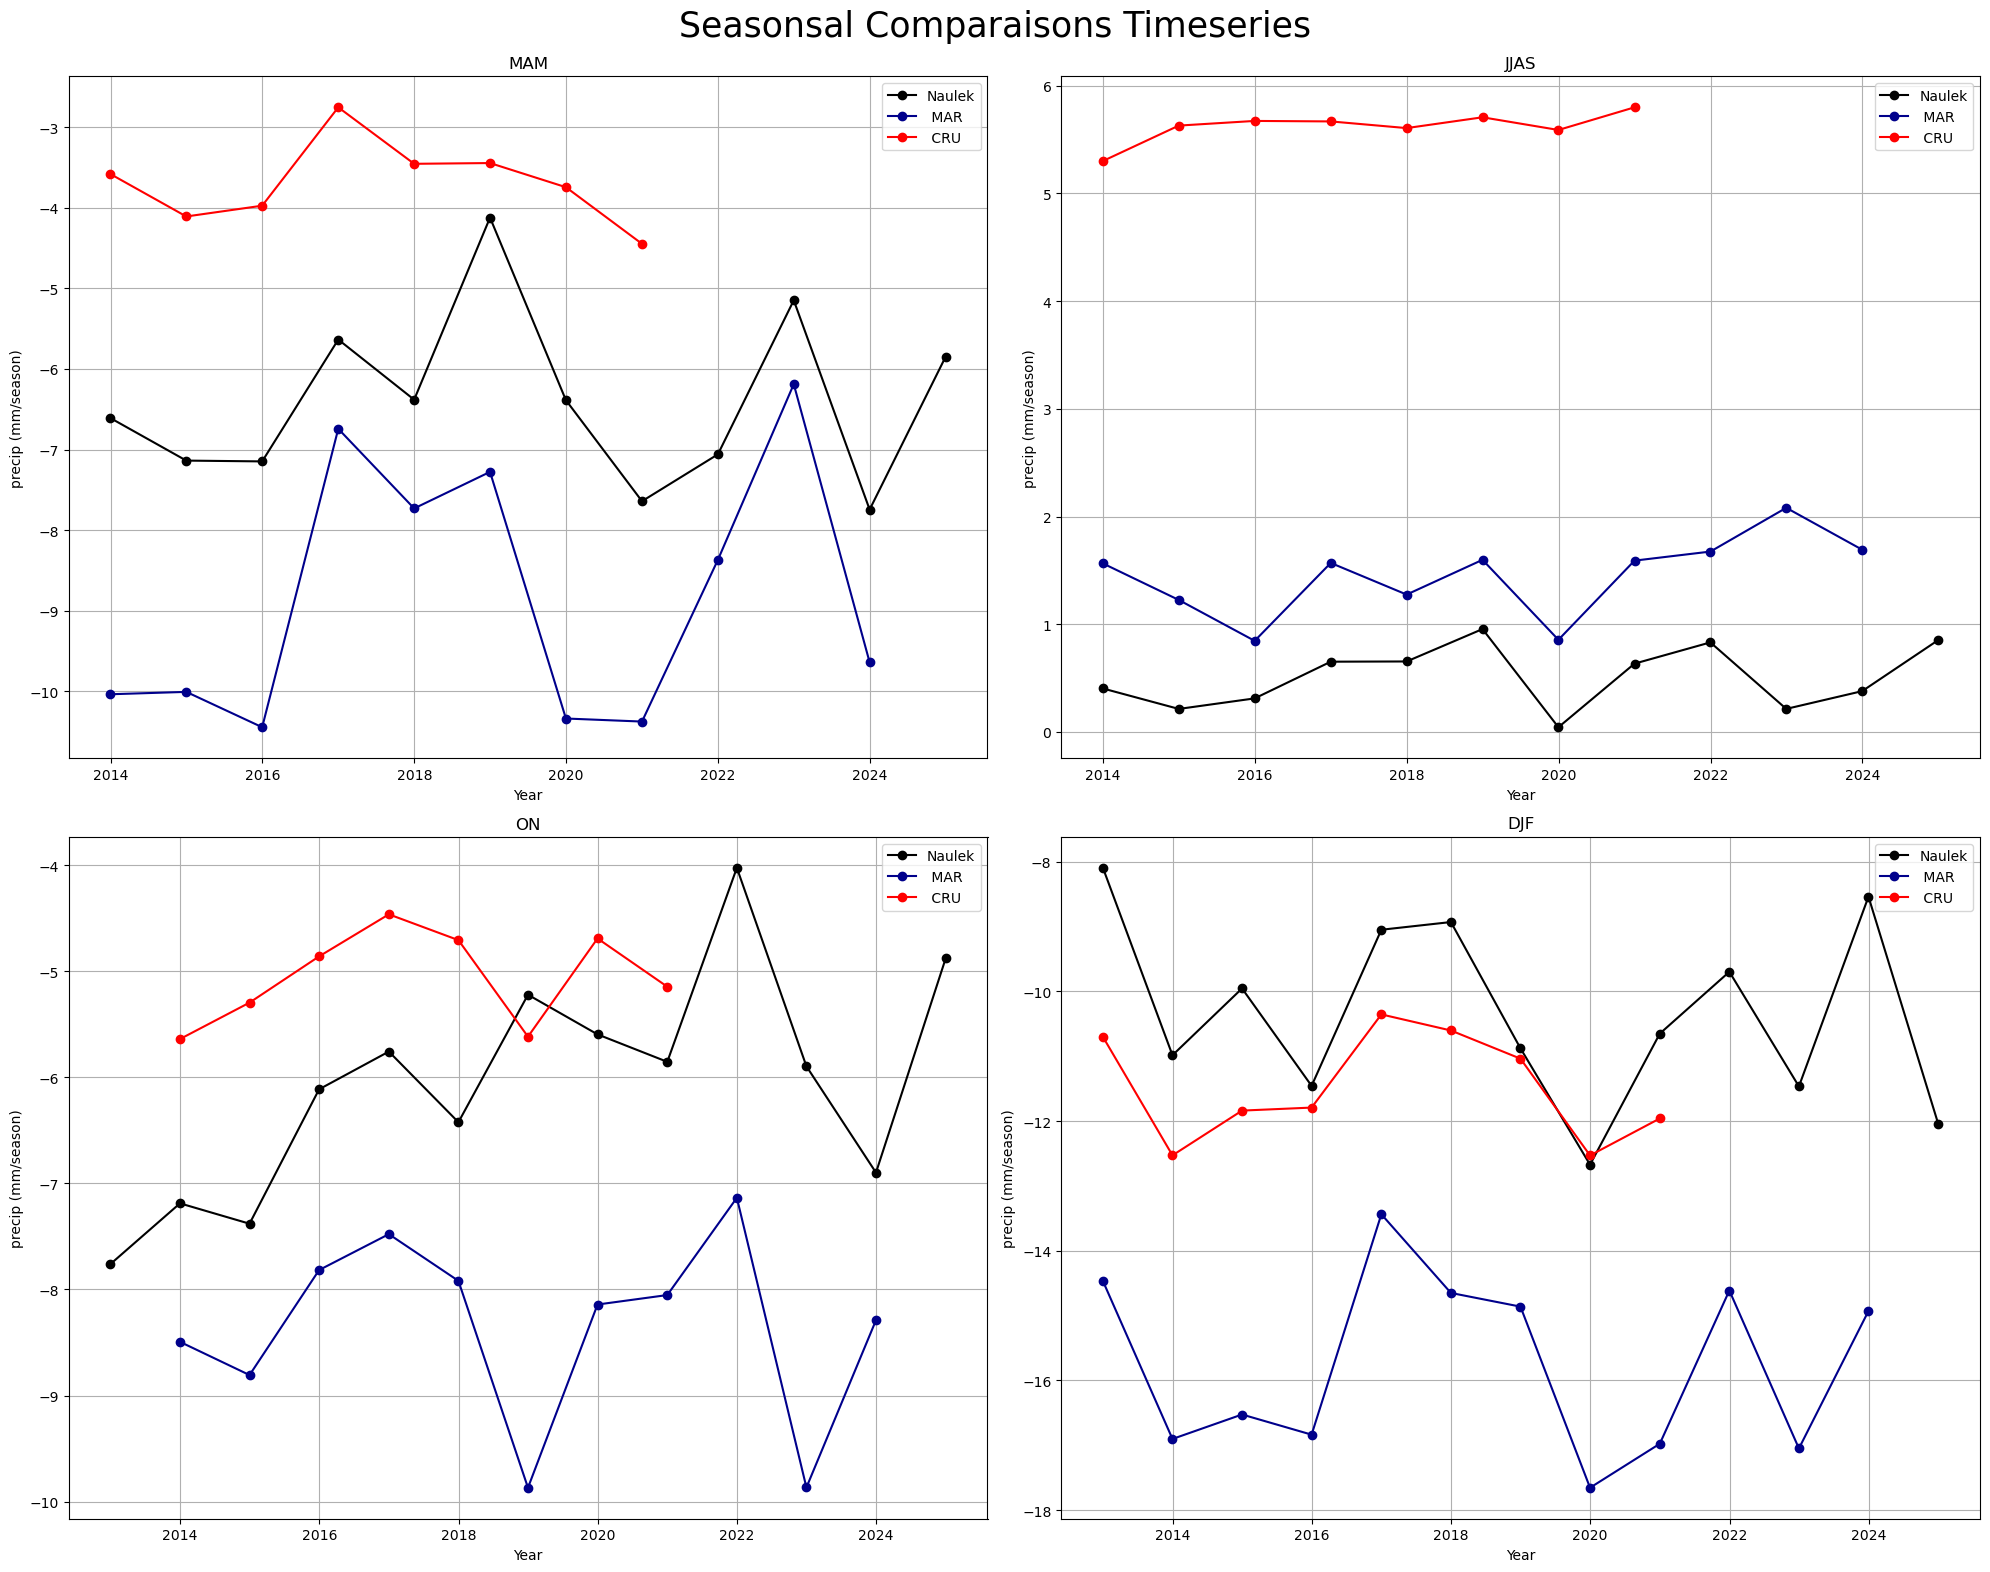

In [49]:
#Time Series
fig, axes = plt.subplots(2, 2, figsize=(20, 16))
axes = axes.flatten()

for thing, x in enumerate(seasons):
    ax = axes[thing]

    # Pyramide
    da_py = seasonal_T_station['Tair'][x]
    # MAR
    da_mar = seasonnal_T_MAR[x]
    #Cru
    da_cru= seasonnal_T_CRU[x]
  

    # Tracés
    ax.plot(da_py.time, da_py.values, linestyle='-', marker='o', label=station,color='black')
    ax.plot(da_mar.time, da_mar.values, linestyle='-', marker='o', label=' MAR',color='darkblue')
    ax.plot(da_cru.time, da_cru.values, linestyle='-', marker='o', label=' CRU',color='red')

    # Mise en forme
    ax.set_title(titles[x])
    ax.set_xlabel('Year')
    ax.set_ylabel('precip (mm/season)')
    ax.grid(True)
    ax.legend()


plt.tight_layout(rect=[0, 0, 1, 0.96])  # Maria script theft : leave space for the suptitle
fig.suptitle('Seasonsal Comparaisons Timeseries',fontsize=25)
plt.show()


285.87256


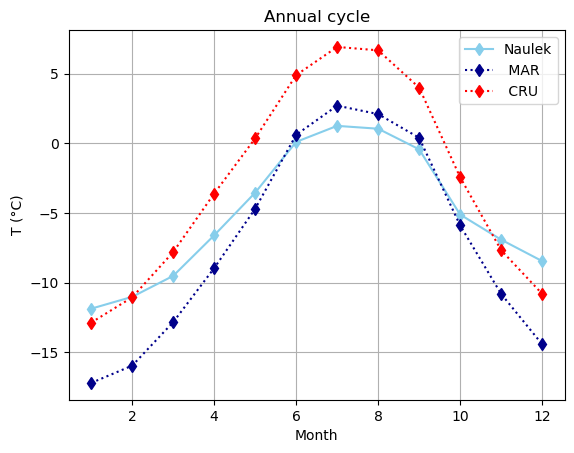

In [52]:
#Annual cycle 
#daily_meanRR=RR.resample(time='D').sum()  
T_cycle_sta=ClimBasis_T_station['monthly'].groupby('time.month').mean()


plt.plot(T_cycle_sta.month,T_cycle_sta.Tair,
        color='skyblue',linestyle='-',label=station,marker='d')
plt.plot(T_MAR_cycle.month,T_MAR_cycle.values,
         color='darkblue',linestyle=':',label=' MAR',marker='d')
plt.plot(T_CRU_Cycle.month,T_CRU_Cycle.values,
         color='red',linestyle=':',label=' CRU',marker='d')    




plt.legend()
plt.title('Annual cycle')
plt.xlabel('Month')
plt.ylabel('T (°C)')

plt.grid(True)
print(diff)

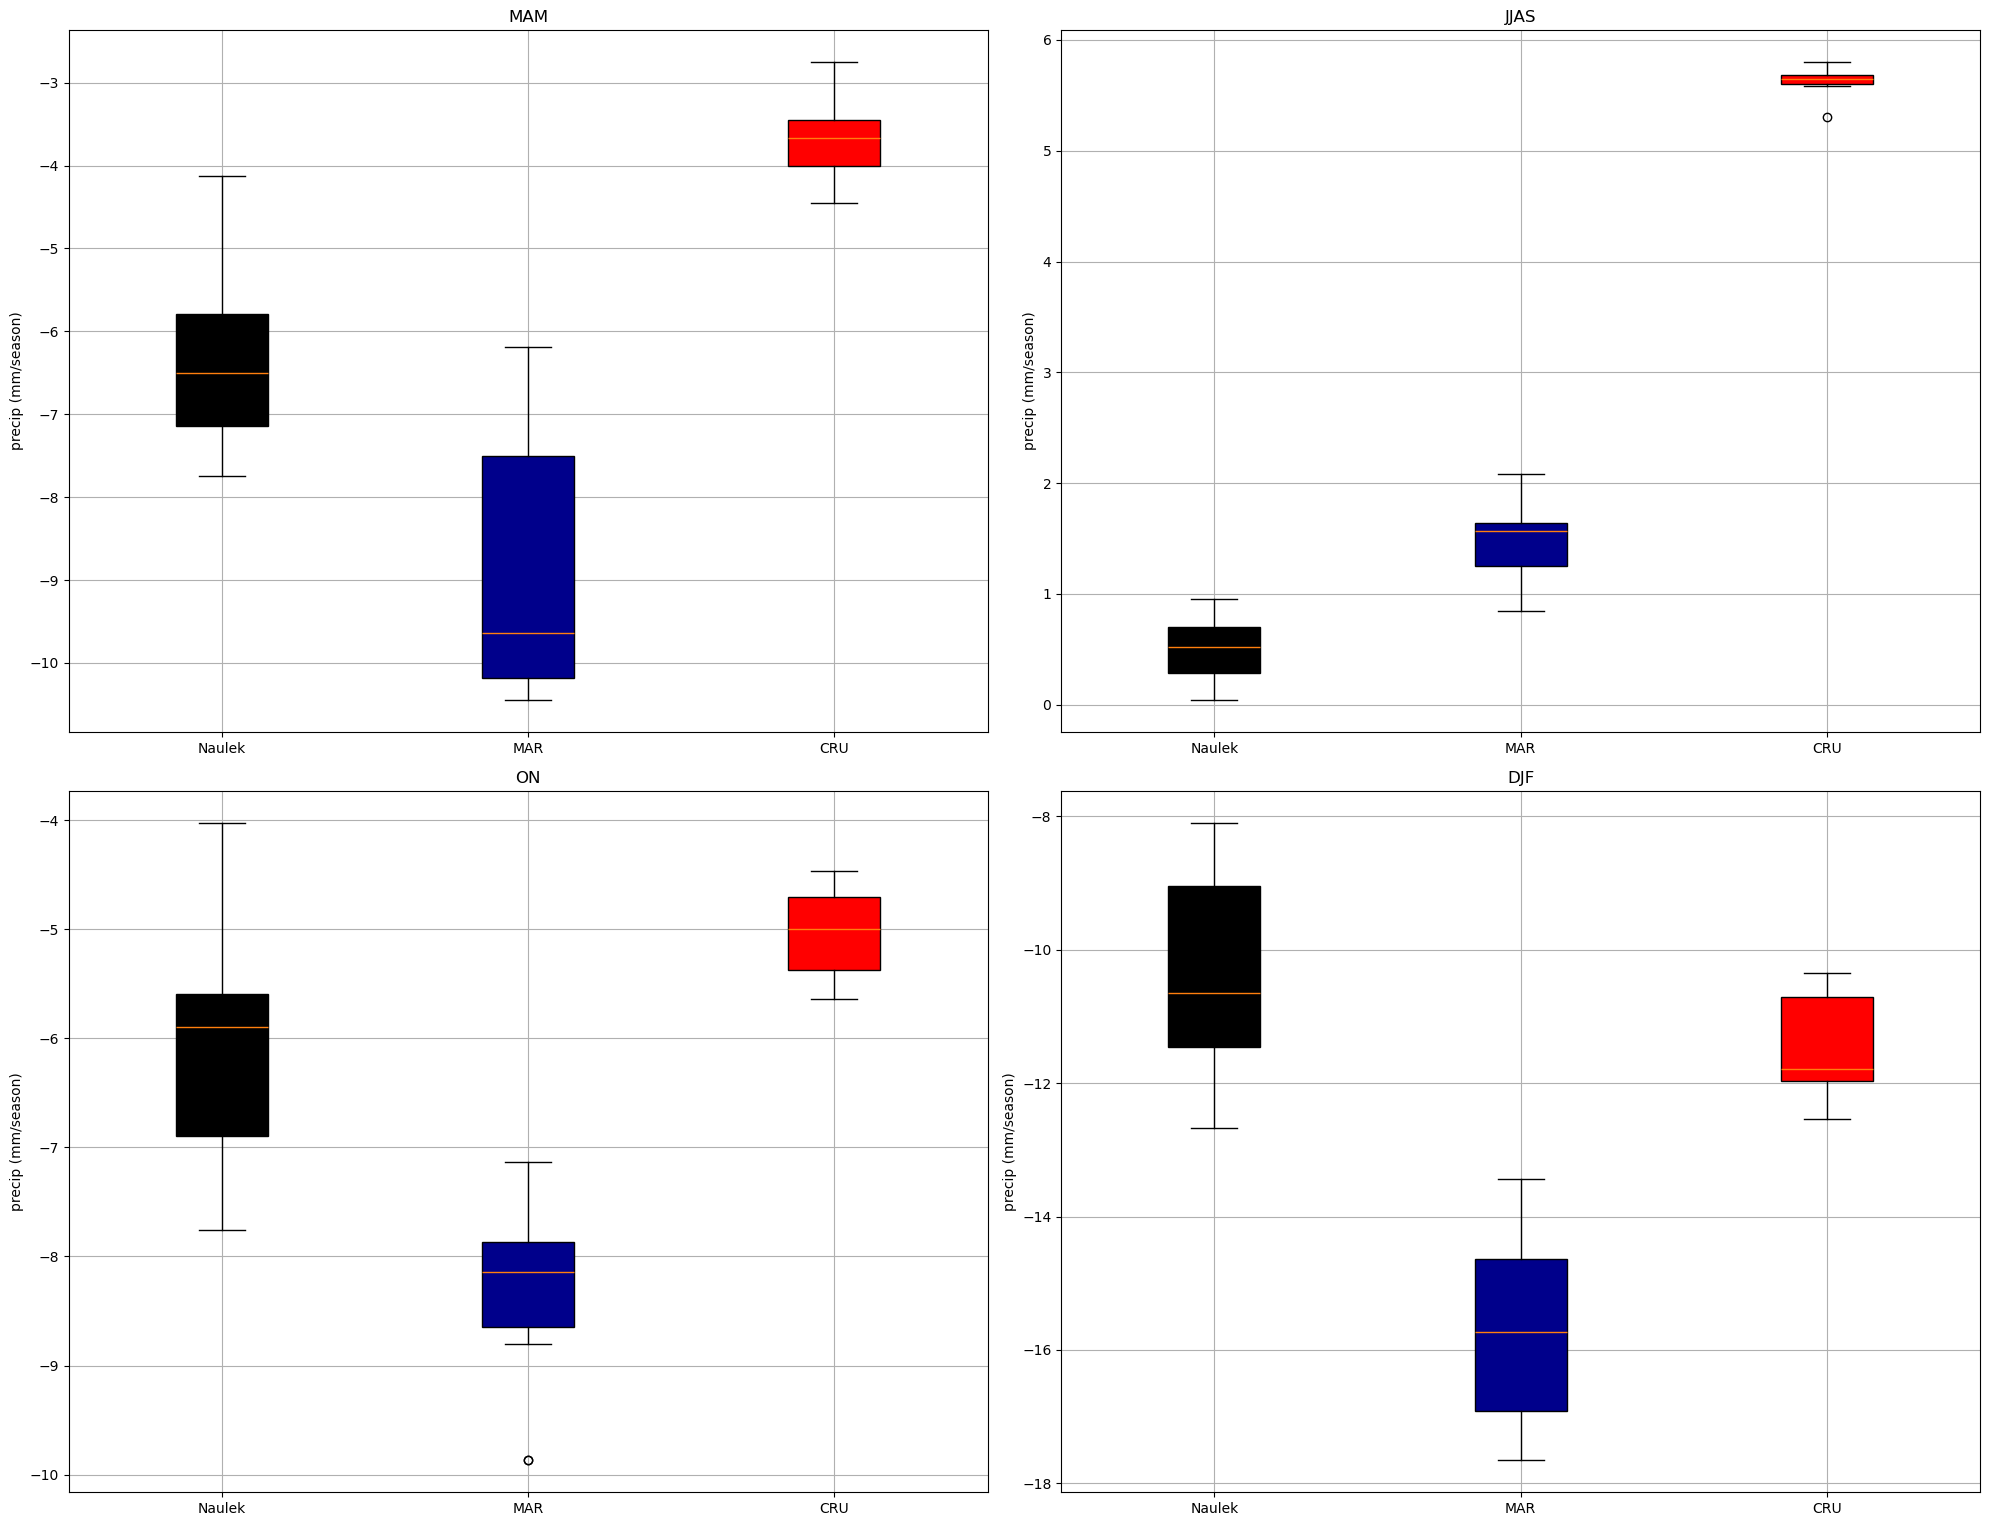

In [51]:
#
fig, axes = plt.subplots(2, 2, figsize=(20, 16))
axes = axes.flatten()

for things, x in enumerate(seasons):
    ax = axes[things]

    # Data
    da_py = seasonal_T_station['Tair'][x].values
    da_mar = seasonnal_T_MAR[x].values
    da_cru = seasonnal_T_CRU[x].values

    # listes
    data = [da_py, da_mar,  da_cru]
    tick_labels = [station, 'MAR',  'CRU']
    colors = ['black', 'darkblue', 'red',]
    
    bp = ax.boxplot(data, patch_artist=True, tick_labels=tick_labels)
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)

    ax.set_title(titles[x])
    ax.set_ylabel('precip (mm/season)')
    ax.grid(True)
    ax.legend
plt.tight_layout(rect=[0, 0, 1, 0.96])
fig.suptitle('', fontsize=20)
plt.show()
